# My Capstone Project: Using Object Detection to Classify Amenities in Vacation Rental Listings

by Jordan Darbyshire

## **Project Overview**

### Motivation

The purpose of this project to identify objects from images of homes uploaded onto vacation rental sites. Potential customers browsing vacation rental sites are looking for specific amenities in their vacation rental. For example, they want an oven to cook in, a pool to swim in, a pool table for entertainment... the list goes on. When a property owner creates an ad on a vacation rental website, they would usually manually type in their amenities or select from a large list. Inaccurate amenities can result in lost revenue due to bad reviews or last-minute cancellations.

Users of the website will search for properties based on their desired amenities, and will be shown a list of properties based on their preferences. What if there was an easier way to add amenities to the listing, simply by uploading the property images without the manual labor? This is where Object Detection come in.

### Inspiration

The inspiration for this project comes from an [article](https://medium.com/airbnb-engineering/amenity-detection-and-beyond-new-frontiers-of-computer-vision-at-airbnb-144a4441b72e) I came across that highlighted an Airbnb computer vision project where they aim to detect room type by the types of objects identified in their listing photos.

I was also interested in this project because of my interest in the Computer Vision field, which is still rapidly evolving. I have a love for travelling, and I have had a lot of experience using these rental sites. 


### Potential Applications

Any hotel or Vacation rental site such as Vrbo, Hotels.com, TripAdvisor, etc.

## **Exploratory Data Analysis**

### About the dataset

The dataset I used for this Capstone project is Open Images V4, which contains 1.99 million images spanning 600 classes. The dataset is open source, put together by Google. It is "the largest existing dataset with object location annotations", it includes bounding boxes manually drawn by humans to ensure accuracy and consistency [Source](https://storage.googleapis.com/openimages/web/factsfigures_v4.html). The images often show complex scenes with several objects (8 annotated objects per image on average) [Source](https://arxiv.org/abs/1811.00982). There are yearly competitions based on this dataset for the purpose of advancing the Computer Vision field.

I chose this dataset due to the large number and variety of the image classes available, and the inclusion of the bounding boxes. If the images did not come with these bounding box "labels", I would have had to create these manually using open source software. To begin this project, I decided that I would choose 20 classes most applicable to this problem. To go about this, I chose the classes most relevant to each room type: Bedroom, Bathroom, Living Room, Kitchen, and Outdoor. On the Open Images website, you are able to download a csv that lists all of the classes contained in this dataset. I filtered the dataset to 30 classes based on what amenities would be the most desirable to the consumer.

### Load packages

In [208]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from pathlib import Path
import urllib
import os
import cv2

import warnings
warnings.filterwarnings("ignore")

### Download the images

I quickly realized that the biggest challenge with starting a project for Object Detection is putting together a dataset to run models on. Since the Open Images dataset is so large, it would be a monumental task to download the full dataset (split into 513GB for training, 12GB for validation and 36GB for testing), and sort through it to get what I need. The Open Images website does not provide an option to download select classes of images. Fortunately, I discovered that there are a few open source solutions to this problem. I attempted a few different "toolkits" that promised to solve this problem by downloading only desired classes. I ended up going with the [OIDv4 ToolKit](https://github.com/EscVM/OIDv4_ToolKit) to complete the task.

In [ ]:
# Download the Toolkit:
#!git clone https://github.com/EscVM/OIDv4_ToolKit.git

The OIDv4 ToolKit finally allowed me to download only the classes I was interested in from the Open Images dataset. Running the OID4 script initiated downloads of the images accompanied with an annotation text file (labels). The annotations have the class of each image and the bounding box coordinates which are used for Object Recognition purposes. Examples of the command to initiate the image downloader are found in the below code cells.

In [ ]:
# Download train set images for desired classes
# The script below allowed me to copy and paste the commands into Anaconda prompt without manually editing each line:
#for name in classes:   
    #print(f"python main.py downloader --classes {name} --type_csv train --limit 750")

I capped the number of images at 750 after observing some classes had tens of thousands of images, while half of my desired classes had less than 750 for each class.

In [98]:
# Look at count of .jpg files in the dataset folder

data_dir = ("data/Dataset_20")
data_dir = pathlib.Path(data_dir)

image_count = len(list(data_dir.glob('*/*.jpg')))
image_count 

11907

### Examine the dataset

After completion of the downloading process, I ended up with 11,907 images (3 GB in size).

Each image is accompanied by a text file that has the class name, and bounding box coordinates. These coordinates consist of four values that correspond to the actual number of pixels of the related image, and define the top left corner and bottom right corner of the bounding box (see below image)

<img src=https://raw.githubusercontent.com/EscVM/OIDv4_ToolKit/master/images/rectangle.png>

### Explore Image Dimensions

In [99]:
# Use OpenCV to read in an image, open a window to view the image
# OpenCV converts the image to a numpy array
example_image = cv2.imread("data/Dataset_20/Bathtub/00a60d051d75144f.jpg", cv2.IMREAD_UNCHANGED)

# Opens a window to display the image
cv2.imshow("image",example_image)
# Wait until user presses a key
cv2.waitKey(0)
# Closes window based on waitforkey parameter
cv2.destroyAllWindows() 

In [100]:
# Get dimensions of an image using OpenCV
# This code is from https://www.tutorialkart.com/opencv/python/opencv-python-get-image-size/

# Read an image
image = cv2.imread("data/Dataset_20/Bathtub/00a60d051d75144f.jpg", cv2.IMREAD_UNCHANGED)
 
# Get dimensions of image using shape
dimensions = image.shape
 
# height, width, number of channels in image
height = image.shape[0]
width = image.shape[1]
channels = image.shape[2]
pixel_num = image.size
 
print("Image Dimension    : ",dimensions)
print("Image Height       : ",height)
print("Image Width        : ",width)
print("Number of Channels : ",channels)
print("Number of pixels   : ",pixel_num)

Image Dimension    :  (1024, 683, 3)
Image Height       :  1024
Image Width        :  683
Number of Channels :  3
Number of pixels   :  2098176


In [ ]:
# Look at the image array
# print(image)

### Visualize the dataset

In [158]:
# WRITE A DOCSTRING FOR THIS FUNCTION

# This function reads through Dataset folders, returns a DataFrame with number of images per class and a visualization
# It was created with help from https://stackoverflow.com/questions/62114998/python-make-dictionary-with-folder-names-as-key-and-file-names-as-values
# and https://thispointer.com/python-pandas-how-to-convert-lists-to-a-dataframe/
import fnmatch
from collections import defaultdict

def visualize_dataset(path):
    
    data_dict=defaultdict(set)
    global data_df
    
    # This code will read the images from the Dataset folder, put them into a dictionary
    for path,dirs,files in os.walk(path):
        for f in fnmatch.filter(files,'*.jpg'):
            data_dict[os.path.basename(path)].add(f)
        
    # Get number of pictures per class, append values to lists (intermediary step to a DataFrame)
    key_list = []
    count_list = []

    # Get number of photos per class(folder)
    for k,v in data_dict.items():
        value = len(list(filter(None, v)))
        key_list.append(k)
        count_list.append(value)

    # Create a zipped list of tuples from above lists
    zippedList =  list(zip(key_list, count_list))

    data_df = pd.DataFrame(zippedList, columns = ["Class" , "Image_Count"])

    data_df = data_df.sort_values(by="Image_Count", ascending=False).reset_index(drop=True)

    print(data_df)
        
    # Make a plot of number of images per class
    plt.figure(figsize=(20,10))
    plt.bar(data_df["Class"], data_df["Image_Count"])
    plt.title("Number of images per class", size=26)
    plt.ylabel("Image count", size=20)
    plt.xticks(rotation=90, size=16)
    plt.yticks(size=16)
    plt.show()

                          Class  Image_Count
0                           Bed          749
1                 Swimming pool          748
2                        Stairs          747
3                         Chair          745
4                          Lamp          731
5                    Television          727
6                         Couch          727
7   Kitchen & dining room table          726
8                Billiard table          666
9                     Fireplace          657
10                       Toilet          632
11                         Sink          617
12                      Bathtub          605
13                 Refrigerator          547
14                    Gas stove          536
15                  Ceiling fan          463
16              Washing machine          425
17                    Microwave          376
18                  Coffeemaker          295
19                         Oven          188


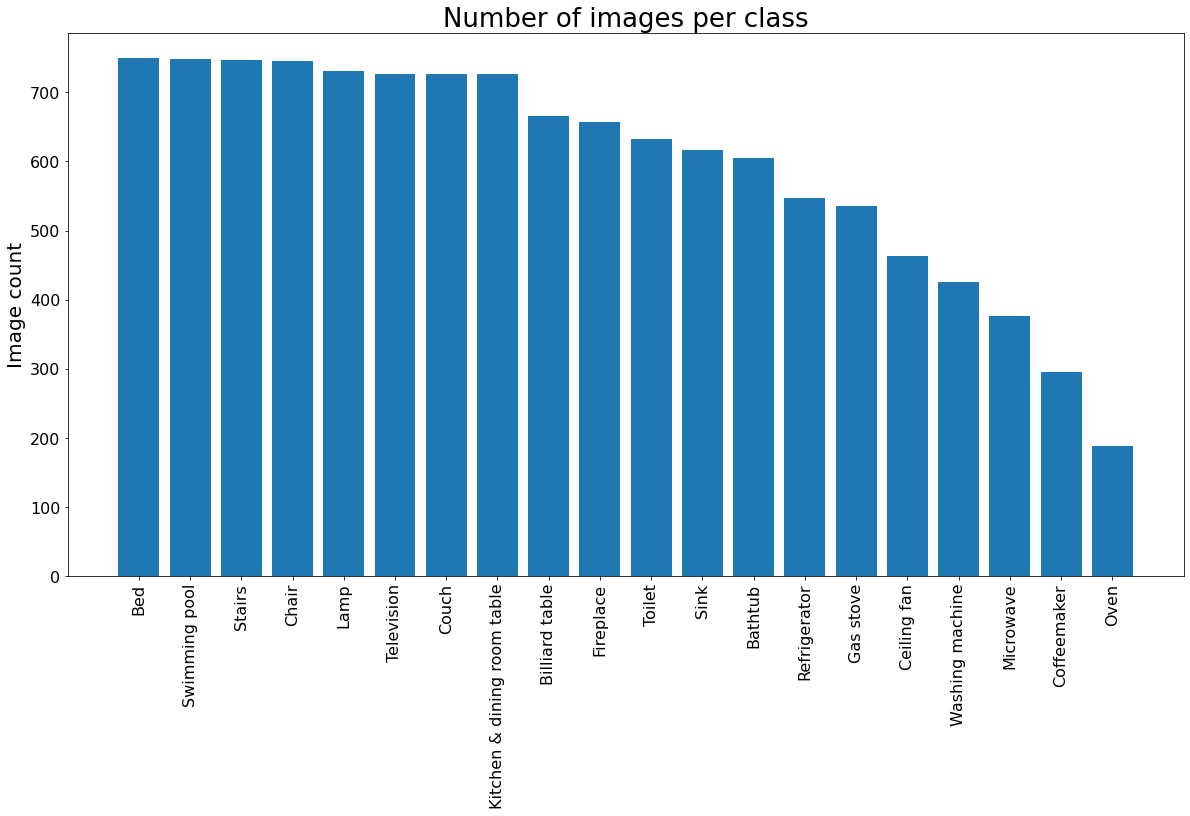

In [159]:
visualize_dataset("data/Dataset_20/")

### Dataset Challenges

After Exploratory Data Analysis, there are two main concerns with this dataset which could affect training accuracy:

1. Class imbalance: \
A solution to the first problem is to employ image augmentation, where copies of images in the unbalanced classes are made by flipping, scaling, or skewing. However due to time constrains, I am going to drop 5 classes that are not well represented in the data. This is also going to help reduce training time by reducing the size of the dataset.

2. Large image dimensions / not consistent:
The images dimenstions differ slightly, however one side is always 1024 pixels. This may or may not be a problem, but the large size of the images will also slow down training. These images may need to be rescaled before being passed into a neural network.

### Drop from 20 to 15 classes

In [97]:
%pwd

'C:\\Users\\jorda\\Documents\\Capstone'

In [72]:
# Remove classes from Dataset folder
# import shutil

# to_delete = ["Oven", "Coffeemaker", "Microwave oven", "Washing machine", "Ceiling fan"]

# for folder in to_delete:

    # Removes entire folder and contents
    # shutil.rmtree(f"Dataset_20/{folder}")
    # print(f"The {folder} folder has been removed")

The Microwave oven folder has been removed
The Washing machine folder has been removed
The Ceiling fan folder has been removed


                          Class  Image_Count
0                           Bed          749
1                 Swimming pool          748
2                        Stairs          747
3                         Chair          745
4                          Lamp          731
5                         Couch          727
6                    Television          727
7   Kitchen & dining room table          726
8                Billiard table          666
9                     Fireplace          657
10                       Toilet          632
11                         Sink          617
12                      Bathtub          605
13                 Refrigerator          547
14                    Gas stove          536


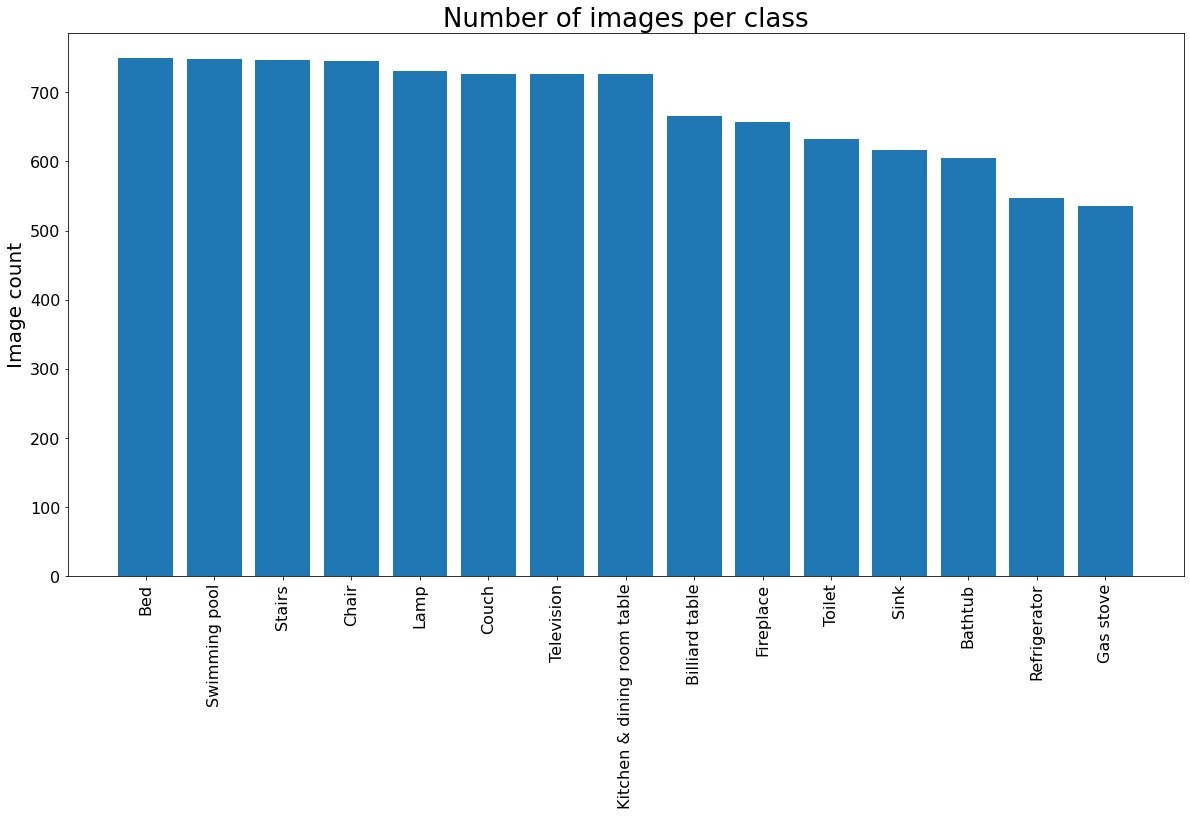

In [160]:
visualize_dataset("data/Dataset_15/")

In [188]:
# Look at count of .jpg files in the dataset folder

data_dir = ("data/Dataset_15")
data_dir = pathlib.Path(data_dir)

image_count = len(list(data_dir.glob('*/*.jpg')))
image_count 

10160

## **Data Pre-processing**

In [216]:
from keras_retinanet import models
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color

## Train/set split

Due to the file structure of my images and annotations, I used a script called "partition_dataset.py" from GitHub to split my image and XML data into 80-20 Train-test sets.

In [207]:
%pwd

'C:\\Users\\jorda\\Documents\\Capstone'

In [ ]:
#!git clone https://github.com/armaanpriyadarshan/Training-a-Custom-TensorFlow-2.X-Object-Detector.git

In [185]:
# Run this command to split the data

#!python partition_dataset.py -i data/Dataset_15_copy -o data/Dataset_15_split -r 0.2 -x
#print(f"The partition was successful")

The partition was successful


## Convert annotations to XML, CSV

In [ ]:
# Download tool to convert txt annotations to PASCAL VOC
#!git clone https://github.com/thehetpandya/OIDv4_annotation_tool.git

In [ ]:
# Now that annotations are in XML (Pascal), need to get them into a single csv file for Keras

In [203]:
# Run the Pascal to CSV program
# Source Code: https://gist.github.com/rotemtam/88d9a4efae243fc77ed4a0f9917c8f6c
import glob
import xml.etree.ElementTree as ET

def xml_to_csv(path):
    xml_list = []
    for xml_file in glob.glob(path + '/*.xml'):
        tree = ET.parse(xml_file)
        root = tree.getroot()
        for member in root.findall('object'):
            bbx = member.find('bndbox')
            xmin = int(bbx.find('xmin').text)
            ymin = int(bbx.find('ymin').text)
            xmax = int(bbx.find('xmax').text)
            ymax = int(bbx.find('ymax').text)
            label = member.find('name').text

            value = (root.find('filename').text,
                     #int(root.find('size')[0].text),
                     #int(root.find('size')[1].text),
                     xmin,
                     ymin,
                     xmax,
                     ymax,
                     label
                     )
            xml_list.append(value)
    column_name = ['image_name', #'width', 'height',
                   'x_min', 'y_min', 'x_max', 'y_max', 'class_name']
    xml_df = pd.DataFrame(xml_list, columns=column_name)
    return xml_df

In [204]:
# Look at the train dataset
train_df = xml_to_csv("data/Dataset_15_split/train")
train_df

,image_name,x_min,y_min,x_max,y_max,class_name
0,00011aec5d7324f4.jpg,651,342,840,426,Gas stove
1,0001cb734adac2ee.jpg,5,5,1020,765,Refrigerator
2,00045a4fa4352fc4.jpg,0,357,952,680,Swimming pool
3,00046bdb3022f7aa.jpg,267,312,330,349,Lamp
4,00056223ec2b5aa1.jpg,0,473,167,767,Chair
...,...,...,...,...,...,...
12984,ffd7e79d4cb18e98.jpg,484,849,553,880,Lamp
12985,ffd7e79d4cb18e98.jpg,512,880,555,913,Lamp
12986,ffdae9dfe9d00503.jpg,242,341,554,652,Fireplace
12987,ffe4978e60297279.jpg,440,431,958,744,Chair


The train data set has 8,127 images, with 12,989 annotations (bounding boxes).

In [205]:
# Look at the test dataset
test_df = xml_to_csv("data/Dataset_15_split/test")
test_df

,image_name,x_min,y_min,x_max,y_max,class_name
0,000325b47e09c6aa.jpg,0,469,128,741,Chair
1,000325b47e09c6aa.jpg,0,546,183,960,Chair
2,00061ea456165593.jpg,196,530,481,761,Sink
3,00061ea456165593.jpg,604,536,875,700,Sink
4,000698b6a00772ac.jpg,463,393,1023,584,Bathtub
...,...,...,...,...,...,...
3286,ff4d029d6b2c461d.jpg,567,577,768,958,Toilet
3287,ff5d89c0517480ad.jpg,0,0,1022,575,Television
3288,ff9b80a751bc3ecc.jpg,51,249,894,803,Television
3289,ffd3a541c54324a3.jpg,167,170,291,245,Sink


The test data set has 2,032 images with 3,291 annotations (bounding boxes).

In [206]:
# Convert DataFrames to a CSV
train_df.to_csv("data/labels_train.csv")
test_df.to_csv("data/labels_test.csv")

Let's visualize the bounding boxes on the images to complete the pre-processing step.

In [217]:
# Source code: https://www.curiousily.com/posts/object-detection-on-custom-dataset-with-tensorflow-2-and-keras-using-python/
def show_image_objects(image_row):
    
    data_folder = Path("data/Dataset_15_split/train")
    
    img_path = data_folder / image_row.image_name 
    box = [
        image_row.x_min, image_row.y_min, image_row.x_max, image_row.y_max
    ]

    image = read_image_bgr(img_path)

    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

    draw_box(draw, box, color=(255, 255, 0))

    plt.axis('off')
    plt.imshow(draw)
    plt.show()

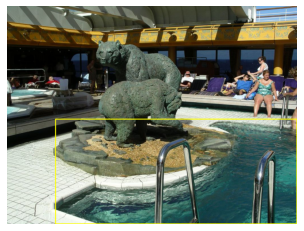

In [219]:
show_image_objects(train_df.iloc[18])

Now we can move ahead and do some modelling!

## Prepare inputs for TensorFlow

Instructions taken from the [Tensorflow Object Detection API](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/using_your_own_dataset.md):
1. Create Label Maps
2. Convert dataset to TFRecord file format

For every example in dataset, we need:\
    - An RGB image for the dataset encoded as jpeg or png.\
    - A list of bounding boxes for the image. Each bounding box should contain:\
        i. A bounding box coordinates (with origin in top left corner) defined by 4 floating point numbers - ymin, xmin, ymax, xmax. Note that we need to store the normalized coordinates (x / width, y / height) in the TFRecord dataset.\
        ii. The class of the object in the bounding box.


**1. Create Label Maps** Now that the annotations are in CSV format, we also need to create a label map which is required to make TFRecords out of dataset.

In [221]:
s = pd.Series(data_df["Class"])
class_list = s.values.tolist()
print(class_list)

['Bed', 'Swimming pool', 'Stairs', 'Chair', 'Lamp', 'Couch', 'Television', 'Kitchen & dining room table', 'Billiard table', 'Fireplace', 'Toilet', 'Sink', 'Bathtub', 'Refrigerator', 'Gas stove']


In [251]:
# Converting the list of classes to label_map.pbtxt

from object_detection.protos.string_int_label_map_pb2 import StringIntLabelMap, StringIntLabelMapItem
from google.protobuf import text_format


def convert_classes(classes, start=1):
    msg = StringIntLabelMap()
    for id, name in enumerate(classes, start=start):
        msg.item.append(StringIntLabelMapItem(id=id, name=name))

    text = str(text_format.MessageToBytes(msg, as_utf8=True), 'utf-8')
    return text


if __name__ == '__main__':
    txt = convert_classes(class_list)
    print(txt)
    with open('label_map.pbtxt', 'w') as f:
        f.write(txt)

item {
  name: "Bed"
  id: 1
}
item {
  name: "Swimming pool"
  id: 2
}
item {
  name: "Stairs"
  id: 3
}
item {
  name: "Chair"
  id: 4
}
item {
  name: "Lamp"
  id: 5
}
item {
  name: "Couch"
  id: 6
}
item {
  name: "Television"
  id: 7
}
item {
  name: "Kitchen & dining room table"
  id: 8
}
item {
  name: "Billiard table"
  id: 9
}
item {
  name: "Fireplace"
  id: 10
}
item {
  name: "Toilet"
  id: 11
}
item {
  name: "Sink"
  id: 12
}
item {
  name: "Bathtub"
  id: 13
}
item {
  name: "Refrigerator"
  id: 14
}
item {
  name: "Gas stove"
  id: 15
}



**2. Convert dataset to TFRecord file format**

Using the Label Map, can generate a tf.Example proto for images using a script based on the TensorFlow Object Detector API. I cloned the following repository, and used the "generate_tfrecord.py" script. 

In [ ]:
#!git clone https://github.com/armaanpriyadarshan/Training-a-Custom-TensorFlow-2.X-Object-Detector.git

In [222]:
#!python generate_tfrecord.py -x Tensorflow/workspace/capstone/images/train -l workspace/capstone/annotations/label_map.pbtxt -o workspace/capstone/annotations/train.record

In [224]:
#!python generate_tfrecord.py -x Tensorflow/workspace/capstone/images/test -l workspace/capstone/annotations/label_map.pbtxt -o workspace/capstone/annotations/test.record

Generation of the TFRecords was successful.

## **Model Training - TensorFlow**

For this project I decided to make use of pre-trained models for object detection, rather than building a model from scratch. The benefit to this is that we are leveraging knowledge (features, weights) from previously trained models to apply to related datasets. In the case of computer vision, low-level features such as edges, shapes, corners and intensity can be shared among tasks (transfer learning). By usng pre-trained models we are saving time and computer resources which is what is needed for this large dataset and the task at hand (object detection).

## Train dataset with pre-trained models

I decided to make use of the CUDA-enabled GPU on my laptop to run the pre-trained models (GeForce GTX 1660-Ti with 6GB of GDDR6 memory).

In [226]:
# Import TensorFlow
import tensorflow as tf
from tensorflow import keras

In [227]:
# Show the TensorFlow version
print(tf.__version__)

2.3.0


Turn on memory growth for GPU by running the following code prior to allocating any tensors or executing any ops [Source: TensorFlow - Using a GPU](https://www.tensorflow.org/guide/gpu). Attempts to allocate only as much GPU memory as needed for the runtime allocations.

In [228]:
# Run the following code before executing anything
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)


1 Physical GPUs, 1 Logical GPUs


## Pre-trained model no. 1: ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8

### Background:

Released in 2019, this model is a Single Shot Detector (SSD) model that goes straight from image pixels to bounding box coordinates and class probabilities. By using SSD, we only need to take one single shot to detect multiple objects within the image. Compare this to R-CNN that needs two shots, one for generating region proposals, one for detecting the object of each proposal. Thus, SSD is much faster compared with two-shot RPN based approaches. [Source](https://towardsdatascience.com/review-ssd-single-shot-detector-object-detection-851a94607d11). The model architecture is based on inverted residual structure where the input and output of the residual block are thin bottleneck layers as opposed to traditional residual models. Moreover, nonlinearities are removed from intermediate layers and lightweight depthwise convolution is used. This model is part of the Tensorflow object detection API. [Source](https://resources.wolframcloud.com/NeuralNetRepository/resources/SSD-MobileNet-V2-Trained-on-MS-COCO-Data)

The SSD Mobilenet V2 is an Object detection model with FPN-lite feature extractor, shared box predictor and focal loss, trained on COCO 2017 dataset with training images scaled to 640x640 [Source](https://tfhub.dev/tensorflow/ssd_mobilenet_v2/fpnlite_640x640/1). Focal loss is very useful for dealing with class imbalance, especially in object detection tasks. The loss function is a dynamically scaled cross-entropy loss, where the scaling factor decays to zero as confidence in the correct class increases. [Source](https://medium.com/analytics-vidhya/how-focal-loss-fixes-the-class-imbalance-problem-in-object-detection-3d2e1c4da8d7)

<img src=https://cdn-images-1.medium.com/max/1000/1*GmJiirxTSuSVrh-r7gtJdA.png>

## Pre-trained model no. 2: RetinaNet + Keras

### Background

Used this [guide](https://www.curiousily.com/posts/object-detection-on-custom-dataset-with-tensorflow-2-and-keras-using-python/) to train a RetinaNet object detection model.

In [ ]:
#!git clone https://github.com/fizyr/keras-retinanet.git

In [ ]:
# Install keras-retinanet
# %cd keras-retinanet/
#! pip install .

## Get data in format required for Keras

In [231]:
# Keras requires two input files

ANNOTATIONS_FILE = "annotations.csv"
CLASSES_FILE = "classes.csv"

In [232]:
# Look at class list created previously
class_list

['Bed',
 'Swimming pool',
 'Stairs',
 'Chair',
 'Lamp',
 'Couch',
 'Television',
 'Kitchen & dining room table',
 'Billiard table',
 'Fireplace',
 'Toilet',
 'Sink',
 'Bathtub',
 'Refrigerator',
 'Gas stove']

In [233]:
# Create numbers for the classes (indexing starts at 0)
class_number = list(np.arange(0, 20))
class_number

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

In [234]:
# Put the two lists together into a DataFrame
class_tuples = list(zip(class_list,class_number))
classes_df = pd.DataFrame(class_tuples)

In [235]:
# Headers need to be removed
classes_df.to_csv(CLASSES_FILE, index=False, header=None)

In [236]:
# Headers need to be removed
train_df.to_csv(ANNOTATIONS_FILE, index=False, header=None)

### Training

Download pre-trained model from RetinaNet

In [250]:
%pwd

'C:\\Users\\jorda\\Documents\\Capstone\\keras-retinanet\\keras_retinanet\\bin'

In [248]:
PRETRAINED_MODEL = './snapshots/_pretrained_model.h5'

URL_MODEL = 'https://github.com/fizyr/keras-retinanet/releases/download/0.5.1/resnet50_coco_best_v2.1.0.h5'

urllib.request.urlretrieve(URL_MODEL, PRETRAINED_MODEL)

print('Downloaded pretrained model to ' + PRETRAINED_MODEL)

Downloaded pretrained model to ./snapshots/_pretrained_model.h5


In [ ]:
# Start TensorBoard to monitor training
#!tensorboard --logdir=keras_retinanet\bin\logs\train

In [286]:
# Ensure GPU is being used
!nvidia-smi

Tue Sep 08 12:20:25 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 452.06       Driver Version: 452.06       CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 166... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   48C    P8     5W /  N/A |   5318MiB /  6144MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                                  |
|  GPU  

In [252]:
# Initiate training for 50 epochs
!python train.py \
    --tensorboard-dir logs \
    --freeze-backbone \
    --random-transform \
    --weights {PRETRAINED_MODEL} \
    --batch-size 5 \
    --steps 500 \
    --epochs 50 \
    --gpu 0\
    --multi-gpu 1 \
    csv annotations.csv classes.csv

1 Physical GPUs, 1 Logical GPUs
Creating model, this may take a second...
Model: "retinanet"

2020-09-08 02:16:21.457972: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library cudart64_101.dll
2020-09-08 02:16:23.506723: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library nvcuda.dll
2020-09-08 02:16:23.526821: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce GTX 1660 Ti with Max-Q Design computeCapability: 7.5
coreClock: 1.335GHz coreCount: 24 deviceMemorySize: 6.00GiB deviceMemoryBandwidth: 268.26GiB/s
2020-09-08 02:16:23.526842: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library cudart64_101.dll
2020-09-08 02:16:23.529137: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library cublas64_10.dll
2020-09-08 02:16:23.531180: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic libr


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9408        input_1[0][0]                    
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, None, None, 6 256         conv1[0][0]                      
__________________________________________________________________________________________________
conv1_relu (Activation)         (None, None, None, 6 0           bn_conv1[0][0]                   
__________________________________________________________________________________________________
pool1 (Ma


2020-09-08 02:16:24.030336: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1263]      0 
2020-09-08 02:16:24.030341: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1276] 0:   N 
2020-09-08 02:16:24.030474: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1402] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 4743 MB memory) -> physical GPU (device: 0, name: GeForce GTX 1660 Ti with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 7.5)
2020-09-08 02:16:24.033683: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x2cd70e5d240 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2020-09-08 02:16:24.033702: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): GeForce GTX 1660 Ti with Max-Q Design, Compute Capability 7.5
2020-09-08 02:17:00.407124: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2020-09-08 02:17:00.408239: I tensorflow

bn3d_branch2b (BatchNormalizati (None, None, None, 1 512         res3d_branch2b[0][0]             
__________________________________________________________________________________________________
res3d_branch2b_relu (Activation (None, None, None, 1 0           bn3d_branch2b[0][0]              
__________________________________________________________________________________________________
res3d_branch2c (Conv2D)         (None, None, None, 5 65536       res3d_branch2b_relu[0][0]        
__________________________________________________________________________________________________
bn3d_branch2c (BatchNormalizati (None, None, None, 5 2048        res3d_branch2c[0][0]             
__________________________________________________________________________________________________
res3d (Add)                     (None, None, None, 5 0           bn3d_branch2c[0][0]              
                                                                 res3c_relu[0][0]                 
__________


500/500 [==============================] - ETA: 0s - loss: 2.0930 - regression_loss: 1.5340 - classification_loss: 0.5590
Epoch 00005: saving model to ./snapshots\resnet50_csv_05.h5

500/500 [==============================] - 527s 1s/step - loss: 2.0930 - regression_loss: 1.5340 - classification_loss: 0.5590
Epoch 6/50

500/500 [==============================] - ETA: 0s - loss: 2.0828 - regression_loss: 1.5313 - classification_loss: 0.5516
Epoch 00006: saving model to ./snapshots\resnet50_csv_06.h5

500/500 [==============================] - 522s 1s/step - loss: 2.0828 - regression_loss: 1.5313 - classification_loss: 0.5516
Epoch 7/50

500/500 [==============================] - ETA: 0s - loss: 2.0155 - regression_loss: 1.4862 - classification_loss: 0.5293
Epoch 00007: saving model to ./snapshots\resnet50_csv_07.h5

500/500 [==============================] - 519s 1s/step - loss: 2.0155 - regression_loss: 1.4862 - classification_loss: 0.5293
Epoch 8/50

500/500 [========================

500/500 [==============================] - ETA: 0s - loss: 1.9761 - regression_loss: 1.4633 - classification_loss: 0.5128
Epoch 00010: saving model to ./snapshots\resnet50_csv_10.h5

500/500 [==============================] - 515s 1s/step - loss: 1.9761 - regression_loss: 1.4633 - classification_loss: 0.5128
Epoch 11/50

485/500 [============================>.] - ETA: 15s - loss: 1.9339 - regression_loss: 1.4343 - classification_loss: 0.4996


500/500 [==============================] - ETA: 0s - loss: 1.9438 - regression_loss: 1.4414 - classification_loss: 0.5024
Epoch 00011: saving model to ./snapshots\resnet50_csv_11.h5

500/500 [==============================] - 521s 1s/step - loss: 1.9438 - regression_loss: 1.4414 - classification_loss: 0.5024
Epoch 12/50

500/500 [==============================] - ETA: 0s - loss: 1.9700 - regression_loss: 1.4642 - classification_loss: 0.5058
Epoch 00012: saving model to ./snapshots\resnet50_csv_12.h5

500/500 [==============================] - 514s 1s/step - loss: 1.9700 - regression_loss: 1.4642 - classification_loss: 0.5058
Epoch 13/50

500/500 [==============================] - ETA: 0s - loss: 1.9822 - regression_loss: 1.4669 - classification_loss: 0.5152
Epoch 00013: saving model to ./snapshots\resnet50_csv_13.h5

Epoch 00013: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.

500/500 [==============================] - 511s 1s/step - loss: 1.9822 - regression_loss: 

500/500 [==============================] - ETA: 0s - loss: 1.9206 - regression_loss: 1.4310 - classification_loss: 0.4896
Epoch 00018: saving model to ./snapshots\resnet50_csv_18.h5

500/500 [==============================] - 516s 1s/step - loss: 1.9206 - regression_loss: 1.4310 - classification_loss: 0.4896
Epoch 19/50

442/500 [=========================>....] - ETA: 59s - loss: 1.9018 - regression_loss: 1.4132 - classification_loss: 0.4886 


500/500 [==============================] - ETA: 0s - loss: 1.9206 - regression_loss: 1.4276 - classification_loss: 0.4930
Epoch 00019: saving model to ./snapshots\resnet50_csv_19.h5

500/500 [==============================] - 518s 1s/step - loss: 1.9206 - regression_loss: 1.4276 - classification_loss: 0.4930
Epoch 20/50

500/500 [==============================] - ETA: 0s - loss: 1.9255 - regression_loss: 1.4366 - classification_loss: 0.4890
Epoch 00020: saving model to ./snapshots\resnet50_csv_20.h5

Epoch 00020: ReduceLROnPlateau reducing learning rate to 9.999999974752428e-08.

500/500 [==============================] - 520s 1s/step - loss: 1.9255 - regression_loss: 1.4366 - classification_loss: 0.4890
Epoch 21/50

500/500 [==============================] - ETA: 0s - loss: 1.9002 - regression_loss: 1.4144 - classification_loss: 0.4858
Epoch 00021: saving model to ./snapshots\resnet50_csv_21.h5

500/500 [==============================] - 521s 1s/step - loss: 1.9002 - regression_loss: 

475/500 [===========================>..] - ETA: 25s - loss: 1.8639 - regression_loss: 1.3906 - classification_loss: 0.4733


500/500 [==============================] - ETA: 0s - loss: 1.8728 - regression_loss: 1.3971 - classification_loss: 0.4757
Epoch 00026: saving model to ./snapshots\resnet50_csv_26.h5

500/500 [==============================] - 516s 1s/step - loss: 1.8728 - regression_loss: 1.3971 - classification_loss: 0.4757
Epoch 27/50

500/500 [==============================] - ETA: 0s - loss: 1.8908 - regression_loss: 1.4102 - classification_loss: 0.4806
Epoch 00027: saving model to ./snapshots\resnet50_csv_27.h5

500/500 [==============================] - 520s 1s/step - loss: 1.8908 - regression_loss: 1.4102 - classification_loss: 0.4806
Epoch 28/50

500/500 [==============================] - ETA: 0s - loss: 1.8916 - regression_loss: 1.4076 - classification_loss: 0.4840
Epoch 00028: saving model to ./snapshots\resnet50_csv_28.h5

Epoch 00028: ReduceLROnPlateau reducing learning rate to 9.999999717180686e-11.

500/500 [==============================] - 515s 1s/step - loss: 1.8916 - regression_loss: 

500/500 [==============================] - ETA: 0s - loss: 1.9071 - regression_loss: 1.4207 - classification_loss: 0.4864
Epoch 00033: saving model to ./snapshots\resnet50_csv_33.h5

500/500 [==============================] - 515s 1s/step - loss: 1.9071 - regression_loss: 1.4207 - classification_loss: 0.4864
Epoch 34/50

500/500 [==============================] - ETA: 0s - loss: 1.8890 - regression_loss: 1.4088 - classification_loss: 0.4802
Epoch 00034: saving model to ./snapshots\resnet50_csv_34.h5

Epoch 00034: ReduceLROnPlateau reducing learning rate to 9.9999988758398e-14.

500/500 [==============================] - 525s 1s/step - loss: 1.8890 - regression_loss: 1.4088 - classification_loss: 0.4802
Epoch 35/50

 94/500 [====>.........................] - ETA: 6:55 - loss: 2.0181 - regression_loss: 1.4966 - classification_loss: 0.5215


500/500 [==============================] - ETA: 0s - loss: 1.9370 - regression_loss: 1.4385 - classification_loss: 0.4985
Epoch 00035: saving model to ./snapshots\resnet50_csv_35.h5

500/500 [==============================] - 517s 1s/step - loss: 1.9370 - regression_loss: 1.4385 - classification_loss: 0.4985
Epoch 36/50

500/500 [==============================] - ETA: 0s - loss: 1.9006 - regression_loss: 1.4173 - classification_loss: 0.4834
Epoch 00036: saving model to ./snapshots\resnet50_csv_36.h5

Epoch 00036: ReduceLROnPlateau reducing learning rate to 9.999999146890344e-15.

500/500 [==============================] - 518s 1s/step - loss: 1.9006 - regression_loss: 1.4173 - classification_loss: 0.4834
Epoch 37/50

500/500 [==============================] - ETA: 0s - loss: 1.9255 - regression_loss: 1.4425 - classification_loss: 0.4831
Epoch 00037: saving model to ./snapshots\resnet50_csv_37.h5

500/500 [==============================] - 519s 1s/step - loss: 1.9255 - regression_loss: 

500/500 [==============================] - ETA: 0s - loss: 1.8791 - regression_loss: 1.3984 - classification_loss: 0.4808
Epoch 00039: saving model to ./snapshots\resnet50_csv_39.h5

500/500 [==============================] - 519s 1s/step - loss: 1.8791 - regression_loss: 1.3984 - classification_loss: 0.4808
Epoch 40/50

 96/500 [====>.........................] - ETA: 6:47 - loss: 1.8786 - regression_loss: 1.3996 - classification_loss: 0.4790


500/500 [==============================] - ETA: 0s - loss: 1.9064 - regression_loss: 1.4239 - classification_loss: 0.4825
Epoch 00040: saving model to ./snapshots\resnet50_csv_40.h5

Epoch 00040: ReduceLROnPlateau reducing learning rate to 9.999998977483754e-17.

500/500 [==============================] - 513s 1s/step - loss: 1.9064 - regression_loss: 1.4239 - classification_loss: 0.4825
Epoch 41/50

500/500 [==============================] - ETA: 0s - loss: 1.8825 - regression_loss: 1.3931 - classification_loss: 0.4894
Epoch 00041: saving model to ./snapshots\resnet50_csv_41.h5

500/500 [==============================] - 517s 1s/step - loss: 1.8825 - regression_loss: 1.3931 - classification_loss: 0.4894
Epoch 42/50

500/500 [==============================] - ETA: 0s - loss: 1.9258 - regression_loss: 1.4402 - classification_loss: 0.4856
Epoch 00042: saving model to ./snapshots\resnet50_csv_42.h5

Epoch 00042: ReduceLROnPlateau reducing learning rate to 9.999998845134856e-18.

500/500 [

500/500 [==============================] - ETA: 0s - loss: 1.9120 - regression_loss: 1.4268 - classification_loss: 0.4852
Epoch 00043: saving model to ./snapshots\resnet50_csv_43.h5

500/500 [==============================] - 522s 1s/step - loss: 1.9120 - regression_loss: 1.4268 - classification_loss: 0.4852
Epoch 44/50

258/500 [==============>...............] - ETA: 4:08 - loss: 1.8761 - regression_loss: 1.3932 - classification_loss: 0.4830


500/500 [==============================] - ETA: 0s - loss: 1.8866 - regression_loss: 1.4035 - classification_loss: 0.4831
Epoch 00044: saving model to ./snapshots\resnet50_csv_44.h5

Epoch 00044: ReduceLROnPlateau reducing learning rate to 9.999999010570977e-19.

500/500 [==============================] - 512s 1s/step - loss: 1.8866 - regression_loss: 1.4035 - classification_loss: 0.4831
Epoch 45/50

500/500 [==============================] - ETA: 0s - loss: 1.9104 - regression_loss: 1.4252 - classification_loss: 0.4852
Epoch 00045: saving model to ./snapshots\resnet50_csv_45.h5

500/500 [==============================] - 517s 1s/step - loss: 1.9104 - regression_loss: 1.4252 - classification_loss: 0.4852
Epoch 46/50

500/500 [==============================] - ETA: 0s - loss: 1.9153 - regression_loss: 1.4339 - classification_loss: 0.4813
Epoch 00046: saving model to ./snapshots\resnet50_csv_46.h5

Epoch 00046: ReduceLROnPlateau reducing learning rate to 9.999999424161285e-20.

500/500 [

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [255]:
#%ls snapshots

In [254]:
# Load in last checkpoint
model_path = os.path.join("snapshots", sorted(os.listdir("snapshots"), reverse=True)[0])
model_path

'snapshots\\resnet50_csv_50.h5'

In [256]:
# Specify what backbone (type of architecture) was used for the object detection
model = models.load_model(model_path, backbone_name="resnet50")
# Convert model for Keras
model = models.convert_model(model)

In [257]:
# Read in the label classes
labels_to_names = pd.read_csv(CLASSES_FILE, header=None).T.loc[0].to_dict()
labels_to_names

{0: 'Bed',
 1: 'Swimming pool',
 2: 'Stairs',
 3: 'Chair',
 4: 'Lamp',
 5: 'Couch',
 6: 'Television',
 7: 'Kitchen & dining room table',
 8: 'Billiard table',
 9: 'Fireplace',
 10: 'Toilet',
 11: 'Sink',
 12: 'Bathtub',
 13: 'Refrigerator',
 14: 'Gas stove'}

In [258]:
# Function #1: Get predictions from model
def predict(image):

    image = preprocess_image(image.copy())
    # Re-size and preprocess the image
    image, scale = resize_image(image)
    # Add additional dimension to image tensor
    boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))
    # Rescale detected boxes based on the resized iamge scale
    boxes /= scale
    # Return all predictions
    return boxes, scores, labels

In [259]:
# Function #2: Draw detected boxes on the image
# Set minimum threshold score
THRES_SCORE = 0.3

def draw_detections(image, boxes, scores, labels):

    for box, score, label in zip(boxes[0], scores[0], labels[0]):
        if score < THRES_SCORE:
            break

    color = label_color(label)

    b = box.astype(int)
    draw_box(image, b, color=color)

    caption = "{} {:.3f}".format(labels_to_names[label], score)
    draw_caption(image, b, caption)

In [260]:
# Function #3: Show detected objects along with predictions
def show_detected_objects(image_row):

    img_path = image_row.image_name
    image = read_image_bgr(img_path)
    boxes, scores, labels = predict(image)
    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)
    true_box = [image_row.x_min, image_row.y_min, image_row.x_max, image_row.y_max]

    draw_box(draw, true_box, color=(255, 255, 0))
    draw_detections(draw, boxes, scores, labels)

    plt.axis('off')
    plt.imshow(draw)
    plt.imsave('predicted_image.jpg', draw)
    
    plt.show()

In [261]:
# Will be running detections on the test images
test_df.head()

,image_name,x_min,y_min,x_max,y_max,class_name
0,000325b47e09c6aa.jpg,0,469,128,741,Chair
1,000325b47e09c6aa.jpg,0,546,183,960,Chair
2,00061ea456165593.jpg,196,530,481,761,Sink
3,00061ea456165593.jpg,604,536,875,700,Sink
4,000698b6a00772ac.jpg,463,393,1023,584,Bathtub


In [264]:
cd test

C:\Users\jorda\Documents\Capstone\keras-retinanet\keras_retinanet\bin\test


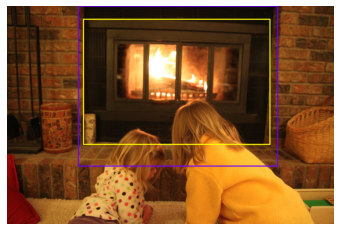

In [284]:
# Yellow boxes are the true annotation, blue are the detected objects with confidence score above 0.3
show_detected_objects(test_df.iloc[217])

Looking at a few of the test images, a little less than 50% are classified correctly.

## Pre-trained model no. 3: YOLOv3

### Background:

I decided to try YOLOv3 due to speed (100x faster than Fast R-CNN). YOLO (You Only Look Once) looks at the whole image at test time so it's predictions are informed by global context in the image. It makes predictions with a single network evaluation unlike systems like R-CNN which require thousands for a single image [Source](https://pjreddie.com/darknet/yolo/). YOLO3 uses Darknet-53 as its backbone feature extractor, which has 53 convolutional layers trained on ImageNet. For the task of detection, 53 more layers are stacked onto it, giving us a 106 layer fully convolutional underlying architecture for YOLO v3 [Source](https://towardsdatascience.com/yolo-v3-object-detection-53fb7d3bfe6b). YOLO3 is better (in terms of Average Precision) than Faster R-CNN for small objects, but behind RetinaNet. It is not as accurate as other models for medium and large objects.

YOLOv3 makes detections on 3 different scales.  YOLO is a fully convolutional network and its eventual output is generated by applying a 1 x 1 kernel on a feature map. In YOLO v3, the detection is done by applying 1 x 1 detection kernels on feature maps of three different sizes at three different places in the network [Source](https://towardsdatascience.com/yolo-v3-object-detection-53fb7d3bfe6b).

<img src=https://miro.medium.com/max/1000/1*d4Eg17IVJ0L41e7CTWLLSg.png>

## Pre-trained model no. 3: VGG

### Model Background

The VGG-16 model is a 16-layer (convolution and fully connected) network built on the ImageNet database, which is built for the purpose of image recognition and classification [Source](https://towardsdatascience.com/a-comprehensive-hands-on-guide-to-transfer-learning-with-real-world-applications-in-deep-learning-212bf3b2f27a). The model achieves 92.7% top-5 test accuracy in ImageNet, which is a dataset of over 14 million images belonging to 1000 classes. It makes use of multiple 3x3 kernel-dized filters one after another. VGG-16 was trained for weeks using NVIDIA Titan Black GPUs.

<img src=https://miro.medium.com/max/605/1*E7zhhan7Sp7hats4jkKdeA.png>

There are a total of 13 convolution layers using 3 x 3 convolution filters along with max pooling layers for downsampling and a total of two fully connected hidden layers of 4096 units in each layer followed by a dense layer of 1000 units, where each unit represents one of the image categories in the ImageNet database. We do not need the last three layers since we will be using our own fully connected dense layers to predict whether images will belong to a certain room type. We are more concerned with the first five blocks, so that we can leverage the VGG model as an effective feature extractor. We will use it as a simple feature extractor by freezing all the five convolution blocks to make sure their weights don’t get updated after each epoch. 

### Get Images into Numpy Arrays

In order for Images to go into a TensorFlow model, they to be read and decoded into integer tensors, then converted to floating point and normalized to small values (between 0 and 1).

In [ ]:
# The below function converts all of the images into numpy arrays
from PIL import Image
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

In [ ]:
from PIL import Image
# We need to get all of the images into arrays, which will be used to combine with the bounding boxes & labels
for image_path in TEST_IMAGE_PATHS:
  image = Image.open(image_path)
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = load_image_into_numpy_array(image)
plt.figure(figsize=IMAGE_SIZE)
plt.imshow(image_np)

#### Scale the data

We need to “Normalize” pixel values (integers between 0-255) to values between 0 and 1 by dividing all pixel values by 255. 
Why? Because large integer values can slow down the ML process. Neural networks process inputs using small weight values )

In [ ]:
# 

X_train = X_train / 255
X_test = X_test / 255